## Importing relevant libraries

In [2]:
import json
import keras
import pandas as pd
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Activation, Embedding
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import json
from keras.models import model_from_json

# Import libraries
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
# nltk.download()
import string
import re
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

import string
import re 

### data 

In [3]:
data = pd.read_csv('./nlp-getting-started/train.csv', encoding='utf-8')
data.head()

id keyword location  \
0   1     NaN      NaN   
1   4     NaN      NaN   
2   5     NaN      NaN   
3   6     NaN      NaN   
4   7     NaN      NaN   

                                                                                                  text  \
0                                Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all   
1                                                               Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...   
3                                    13,000 people receive #wildfires evacuation orders in California    
4             Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school    

   target  
0       1  
1       1  
2       1  
3       1  
4       1

### Data cleaning

In [4]:
#### removing entries where location values are missing
data_after_null_removal = data.copy()

#punctutation removal
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

data_afer_punctuation_removal = data_after_null_removal.copy()
data_afer_punctuation_removal['text'] = data_afer_punctuation_removal['text'].apply(lambda x: clean_text(x))
data_afer_punctuation_removal.head(10)

# Tockenization

def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data_afer_punctuation_removal.copy()
tockenized_data['text'] = tockenized_data['text'].apply(lambda x: tokenization(x.lower()))

# stopword removal 
data_after_stopword_removal = tockenized_data.copy()
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

data_after_stopword_removal['text'] = data_after_stopword_removal['text'].apply(lambda x: remove_stopwords(x))

# return to string
data_without_tockenization = data_after_stopword_removal.copy()
def listToString(s):     
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
data_without_tockenization['text'] = data_without_tockenization['text'].apply(lambda x: listToString(x))
#data_without_tockenization
# Removing duplicates
data_after_duplicate_removal = data_without_tockenization.drop_duplicates(subset=['text'])
data_after_duplicate_removal

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                                                                     text  \
0                                                            deeds reason earthquake may allah forgive us   
1                                                                   forest fire near la ronge sask canada   
2                residents asked shelter place notified officers evacuation shelter place orders expected   
3                                                  people receive wildfires evacuation orders california    
4                                                got sent photo ruby alaska smoke wildfires pours school    
...                                                                                                   ...   
7608                                               two giant cranes holding bridge collapse nearby homes    
7609              ariaahrary thetawniest control wild fires california even northern part state troubling   
7610                                                                                      volcano hawaii    
7611  police investigating ebike collided car little portugal ebike rider suffered serious nonlife thr...   
7612                                            latest homes razed northern california wildfire abc news    

      target  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
7608       1  
7609       1  
7610       1  
7611       1  
7612       1  

[7613 rows x 5 columns]

In [5]:
df = data_without_tockenization.copy()

sentences = df['text'].values
y = df['target'].values

In [6]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.1, random_state=42, shuffle=True)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<6851x15374 sparse matrix of type '<class 'numpy.int64'>'
	with 59212 stored elements in Compressed Sparse Row format>

In [8]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

cooking earlier got electrocuted crucial im psychic lol
[1413, 28, 358, 3, 82]


In [ ]:
# import these modules 
from nltk.stem import WordNetLemmatizer

# Lematizing the words
lemmatizer = WordNetLemmatizer()

# Not sure how to proceed
for text in X_train:
    word = lemmatizer.lemmatize(text)

In [9]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [10]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [11]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('./nlp-getting-started/glove.twitter.27B/glove.twitter.27B.50d.txt',
                                           tokenizer.word_index, embedding_dim)

In [13]:
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           769850    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 770,371
Trainable params: 521
Non-trainable params: 769,850
_________________________________________________________________


In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [15]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)])


Epoch 1/50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
686/686 [==============================] - 8s 11ms/step - loss: 0.5975 - accuracy: 0.6840 - precision: 0.6521 - recall: 0.5625 - val_loss: 0.5364 - val_accuracy: 0.7441 - val_precision: 0.7621 - val_recall: 0.6101
Epoch 2/50
686/686 [==============================] - 7s 10ms/step - loss: 0.5308 - accuracy: 0.7422 - precision: 0.7109 - recall: 0.6712 - val_loss: 0.5049 - val_accuracy: 0.7677 - val_precision: 0.7829 - val_recall: 0.6548
Epoch 3/50
686/686 [==============================] - 7s 10ms/step - loss: 0.5126 - accuracy: 0.7530 - precision: 0.7266 - recall: 0.6790 - val_loss: 0.4922 - val_accuracy: 0.7769 - val_precision: 0.7515 - val_recall: 0.7381
Epoch 4/50
686/686 [==============================] - 7s 11ms/step - loss: 0.5041 - accuracy: 0.7586 - precision: 0.7313 - recall: 0.6899 - val_loss: 0.4869 - val_accuracy: 0.7835 - val_precision: 0.7767 - val_recall: 0.7143
Epoch 5/50
686/686 

In [20]:
glove_model = model.to_json()
with open('./NN_Models/glove_mlp_model.json', 'w') as json_file:
    json_file.write(glove_model)

model.save_weights('./NN_Models/glove_mlp_model.h5')

print('saved model!')

saved model!


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


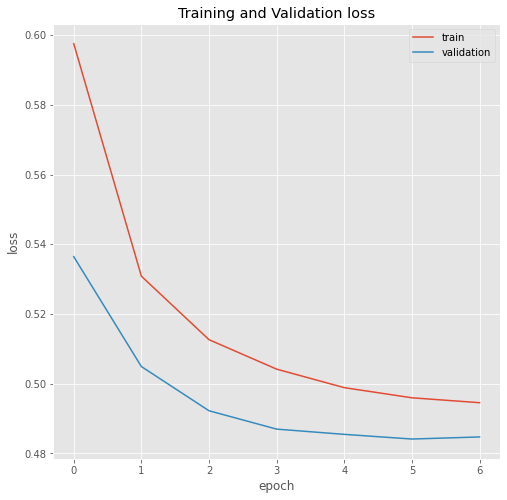

In [21]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [22]:
model.evaluate(X_train, y_train, verbose=False)


[0.4884003698825836,
 0.7730258107185364,
 0.7548006176948547,
 0.6964224576950073]

In [23]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=False)

In [24]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)

def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

Instructions for updating:
Please use Model.predict, which supports generators.


Negative  Positive
Negative       362        64
Positive       101       235

In [25]:
results

Value
Accuracy   0.783465
Precision  0.785953
FPR        0.150235
Recall     0.699405
F1         0.740157